### Putting a vector into a superposition (Grover and Rudolph, 2008)

#### Under the hood:

In [491]:
import cirq
import numpy as np
import matplotlib.pyplot as plt


# goal is putting a classical vector into a quantum mechanical superposition
# the procedure follows 'Grover and Rudolph (2008)'
# length of vector must be smaller/equal 2^(number of qubits)
# the function automatically lengthens x with an array of zeros to the next power of 2
def superposition(x, qubits):
    N = len(qubits)
    x = np.append(x, np.zeros(2 ** N - len(x)))                     # adjust length of x
    powers = np.array([2 ** (N - 1 - i) for i in range(N)])
    for level in range(N):           # go through levels (by definition -> level refers to the currently rotated qubit)
        level += 1
        if level == 1:  # special circuit for level 1 --> no controlled operation is required
            angle = determine_angle(x, 0, len(x) - 1)
            yield cirq.Ry(2 * angle)(qubits[0])
        else:
            permutations = give_binary_vectors(level, N)         # each perm of length (level-1) represents a branch
            for current, perm in enumerate(permutations):        # iterate over branches
                xl = np.dot(perm, powers)                        # determine boundaries of integral-function
                if current == len(permutations) - 1:
                    xr = 2 ** N - 1
                else:
                    xr = np.dot(permutations[current + 1], powers) - 1
                angle = determine_angle(x, int(xl), int(xr))     # call integral-function to determine rotation angle

                for k in range(level - 1):                       # prepare desired state |xx...x0> to |11...10>
                    if perm[k] == 0.:
                        yield cirq.X(qubits[k])

                if level == 2:                                   # conduct controlled rotation (I should be able to
                    yield cirq.Ry(2 * angle).controlled_by(      # clean it up a bit)
                        qubits[0]
                        ).on(qubits[1])
                elif level == 3:
                    yield cirq.Ry(2 * angle).controlled_by(
                        qubits[0], qubits[1]
                        ).on(qubits[2])
                elif level == 4:
                    yield cirq.Ry(2 * angle).controlled_by(
                        qubits[0], qubits[1], qubits[2]
                    ).on(qubits[3])
                elif level == 5:
                    yield cirq.Ry(2 * angle).controlled_by(
                        qubits[0], qubits[1], qubits[2], qubits[3]
                        ).on(qubits[4])
                elif level == 6:
                    yield cirq.Ry(2 * angle).controlled_by(
                        qubits[0], qubits[1], qubits[2], qubits[3], qubits[4]
                        ).on(qubits[5])
                elif level == 7:
                    yield cirq.Ry(2 * angle).controlled_by(
                        qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5]
                        ).on(qubits[6])
                elif level == 8:
                    yield cirq.Ry(2 * angle).controlled_by(
                        qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6]
                        ).on(qubits[7])
                elif level == 9:
                    yield cirq.Ry(2 * angle).controlled_by(
                        qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7]
                        ).on(qubits[8])
                elif level == 10:
                    yield cirq.Ry(2 * angle).controlled_by(
                        qubits[0], qubits[1], qubits[2], qubits[3], qubits[4],
                        qubits[5], qubits[6], qubits[7], qubits[8]
                        ).on(qubits[9])

                for k in range(level - 1):                       # 'unprepare' state
                    if perm[k] == 0.:
                        yield cirq.X(qubits[k])


# xl and xr are first and last index included (!) in the range within x of interest
def determine_angle(x, xl, xr):
    cut = np.int(xl + (xr - xl)/2)
    # prevent error if all current elements are zero
    if np.sum(x[xl:xr+1]) == 0:
        y = 0.5
    else:
        y = np.sum(x[xl:cut+1]) / np.sum(x[xl:xr+1])
    return np.arccos(np.sqrt(y))


# gives all binary vectors on length (level - 1)
def give_binary_vectors(level, N):
    final = []
    for k in range(2**(level-1)):           # go through all numbers (0 to 2^^(m-1))
        number = 2**(level-1) - k - 1
        x = np.zeros(N)
        for j in range(level-1):            # compute binary of number
            x[j], number = modulo_two_addition(number, 2**(level-j-2))
        final.append(np.flip(x))
    return np.flip(final)


# just for convenience
def modulo_two_addition(x, y):
    return (x-x % y)/y, x % y


#### Examples:

Proof of concept:

0: ───Ry(0.5π)───X───@────────────X───@────────────X───@────────────X───X───@───────────X───@───────────────@────────────
                     │                │                │                    │               │               │
1: ──────────────────Ry(0.717π)───────Ry(0.283π)───X───@────────────X───────@───────────X───@───────────X───@────────────
                                                       │                    │               │               │
2: ────────────────────────────────────────────────────Ry(0.564π)───────────Ry(0.65π)───────Ry(0.35π)───────Ry(0.436π)───
measurements: (no measurements)
output vector: 0.192|000⟩ + 0.236|001⟩ + 0.333|010⟩ + 0.544|011⟩ + 0.544|100⟩ + 0.333|101⟩ + 0.236|110⟩ + 0.192|111⟩


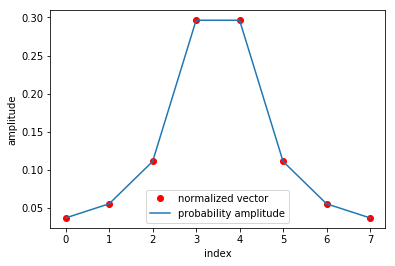

In [493]:
x = np.array([0.5,0.75,1.5,4,4,1.5,0.75,0.5])
qubits = cirq.LineQubit.range(3)

circuit = cirq.Circuit()
circuit.append(superposition(x, qubits))

sim = cirq.Simulator()
result = sim.simulate(circuit)

print(circuit)
print(result)

plt.plot([i for i in range(len(x))], [x[i]/sum(x) for i in range(len(x))], 'ro', label = 'normalized vector')
plt.plot([i for i in range(len(x))], [(result.final_simulator_state.state_vector[i])**2 for i in range(len(x))]
        , label = 'probability amplitude')
plt.xlabel('index')
plt.ylabel('amplitude')
plt.legend()

As we desire to encode MNIST, a more realistic example seems in order. Here an encoding of a vector with 256 elements, randomly alternating between 0 and 1.

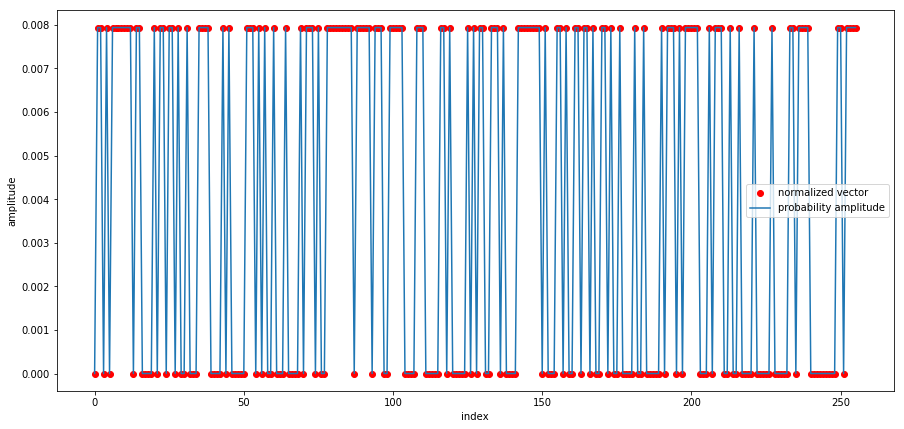

In [555]:
from random import randint

N = 8
x = np.array([randint(0,1) for i in range(2**N)])
qubits = cirq.LineQubit.range(N)

circuit = cirq.Circuit()
circuit.append(superposition(x, qubits))

sim = cirq.Simulator()
result = sim.simulate(circuit)

#print(circuit)
#print(result)

plt.figure(figsize=(15,7))
plt.plot([i for i in range(len(x))], [x[i]/sum(x) for i in range(len(x))], 'ro', label = 'normalized vector')
plt.plot([i for i in range(len(x))], [(result.final_simulator_state.state_vector[i])**2 for i in range(len(x))]
        , label = 'probability amplitude')
plt.xlabel('index')
plt.ylabel('amplitude')
plt.legend()